In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_file = 'data/Occupancy_Estimation.csv'

In [3]:
df = pd.read_csv(data_file)

In [4]:
df.shape

(10129, 19)

In [5]:
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
df["Time"] = pd.to_timedelta(df["Time"])

In [7]:
df.isna().sum()

Date                    0
Time                    0
S1_Temp                 0
S2_Temp                 0
S3_Temp                 0
S4_Temp                 0
S1_Light                0
S2_Light                0
S3_Light                0
S4_Light                0
S1_Sound                0
S2_Sound                0
S3_Sound                0
S4_Sound                0
S5_CO2                  0
S5_CO2_Slope            0
S6_PIR                  0
S7_PIR                  0
Room_Occupancy_Count    0
dtype: int64

In [8]:
df.columns

Index(['Date', 'Time', 'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light',
       'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound',
       'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR',
       'Room_Occupancy_Count'],
      dtype='object')

In [9]:
df.dtypes

Date                     datetime64[ns]
Time                    timedelta64[ns]
S1_Temp                         float64
S2_Temp                         float64
S3_Temp                         float64
S4_Temp                         float64
S1_Light                          int64
S2_Light                          int64
S3_Light                          int64
S4_Light                          int64
S1_Sound                        float64
S2_Sound                        float64
S3_Sound                        float64
S4_Sound                        float64
S5_CO2                            int64
S5_CO2_Slope                    float64
S6_PIR                            int64
S7_PIR                            int64
Room_Occupancy_Count              int64
dtype: object

In [10]:
df['Day_of_Week'] = df['Date'].dt.dayofweek
df['Day_of_Week'] = df['Day_of_Week'].astype('category')

In [11]:
def categorize_time_of_day(time_delta):
    hour = time_delta.seconds // 3600 
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'
df['Part_of_Day'] = df['Time'].apply(categorize_time_of_day)
df['Part_of_Day'] = df['Part_of_Day'].astype('category')

In [12]:
# One hot encoding (to represent categorical variables)
df = pd.get_dummies(df, columns=['Day_of_Week', 'Part_of_Day'])

In [13]:
# Drop Date and Time columns now that we have day of week and part of day info
df = df.drop(['Date', 'Time'], axis=1)

# Correlation Analysis 
In this section, we are checking if columns are independent of each other in order to perform Naive Bayes. 

In [14]:
temp_sensors = ['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp']
temp_sensors

['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp']

In [15]:
light_sensors = ['S1_Light', 'S2_Light', 'S3_Light', 'S4_Light']
light_sensors

['S1_Light', 'S2_Light', 'S3_Light', 'S4_Light']

In [16]:
sound_sensors = ['S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound']
sound_sensors

['S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound']

In [17]:
corr_temp = df[temp_sensors].corr()
corr_light = df[light_sensors].corr()
corr_sound = df[sound_sensors].corr()

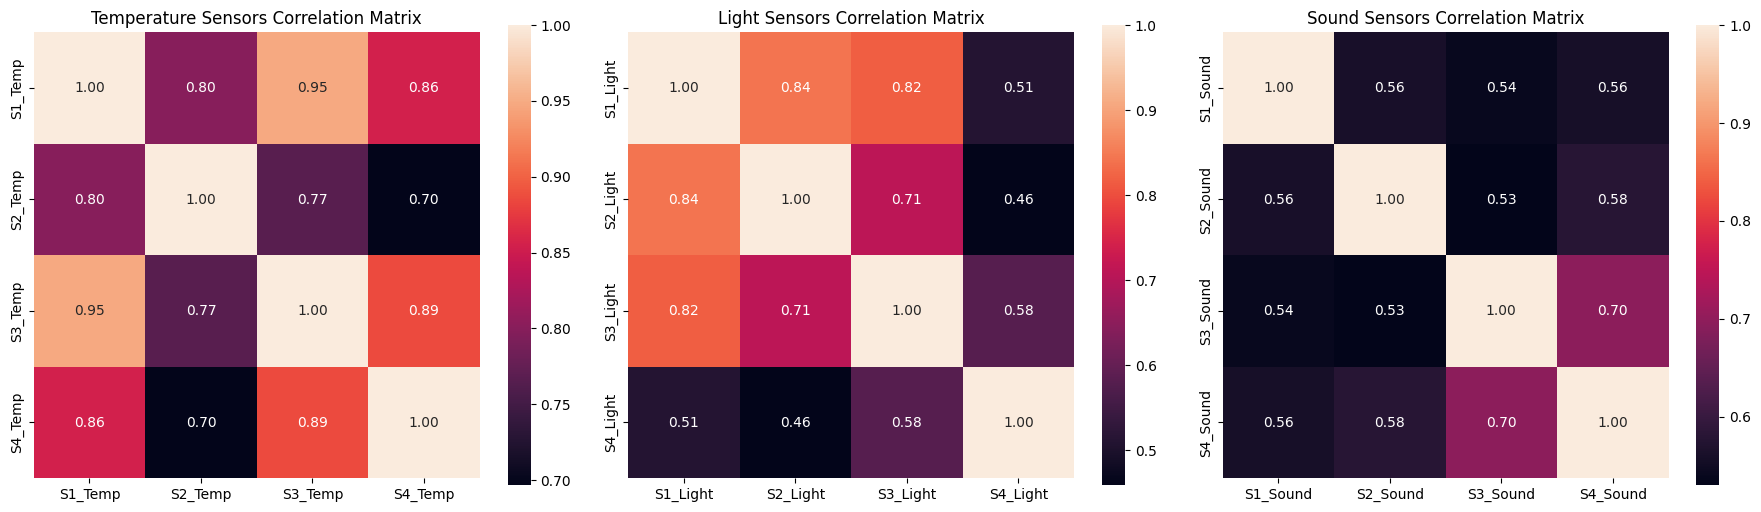

In [18]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.heatmap(corr_temp, annot=True, fmt=".2f", cbar=True, square=True)
plt.title('Temperature Sensors Correlation Matrix')
plt.subplot(1, 3, 2)
sns.heatmap(corr_light, annot=True, fmt=".2f", cbar=True, square=True)
plt.title('Light Sensors Correlation Matrix')
plt.subplot(1, 3, 3)
sns.heatmap(corr_sound, annot=True, fmt=".2f", cbar=True, square=True)
plt.title('Sound Sensors Correlation Matrix')
plt.tight_layout()
plt.show()

## Result of Correlation Matrix

### Temperature Sensors
The correlation coefficients between the temperature sensors are all a bit high.

**S1_Temp** and **S3_Temp** show a very high correlation which is 0.95. This tells us these two sensors often register similar temperature readings. Same applies for **S3_Temp** with **S4_Temp** (0.89) and **S1_Temp** (0.95). **S2_Temp** has the lowest correlations with other sensors but still significant.

These high correlations suggest that the temperature readings across these sensors are consistent. Model with fewer temperature sensors will not losing significant information. 

### Light Sensors
The correlations among light sensors are less than temperature but still generally high.

**S1_Light** and **S2_Light** are highly correlated (0.84), as are **S1_Light** and **S3_Light** (0.82).**S4_Light** shows noticeable lower correlations with the others, particularly with S2_Light (0.46) and S1_Light (0.51). 

### Sound Sensors
The sound sensors show moderate correlations with each other and less redundant compared to temperature sensors. 

The highest correlation is between **S3_Sound** and **S4_Sound** (0.70), which might indicate proximity or similar sound environments.

Other correlations range from 0.53 to 0.58, suggesting that while there is some level of commonality in the sound data captured, each sensor also picks up unique sound information.

### Next Step 
Based on the correlation data from the correlation matrix, it is clear that this assumption does not strictly hold in our dataset, especially among temperature sensors. Therefore, we are dropping some highly correlated features in order to reduce redundancy. 

**Drop S3_Temp:** it is highly correlated with both S1_Temp and S4_Temp. 

**Keeping all light sensors:** Although S1_Light and S2_Light are highly correlated, the correlations among other light sensors are moderate enough to potentially justify keeping all for a more nuanced understanding of light conditions.

**Keep all sound sensors:** The correlations here are moderate, suggesting each captures somewhat unique sound information which might be useful for detailed acoustic analysis.

In [19]:
df = df.drop(['S3_Temp'], axis=1)

In [20]:
df.columns

Index(['S1_Temp', 'S2_Temp', 'S4_Temp', 'S1_Light', 'S2_Light', 'S3_Light',
       'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound', 'S5_CO2',
       'S5_CO2_Slope', 'S6_PIR', 'S7_PIR', 'Room_Occupancy_Count',
       'Day_of_Week_0', 'Day_of_Week_1', 'Day_of_Week_2', 'Day_of_Week_3',
       'Day_of_Week_4', 'Day_of_Week_5', 'Day_of_Week_6',
       'Part_of_Day_Afternoon', 'Part_of_Day_Evening', 'Part_of_Day_Morning',
       'Part_of_Day_Night'],
      dtype='object')

# Split Data

In [22]:
features = df.columns.drop('Room_Occupancy_Count')  
X = df[features]
y = df['Room_Occupancy_Count']

In [23]:
train_df = df.sample(frac=0.8, random_state=1)
test_df = df.drop(train_df.index)

In [24]:
features = train_df.columns.drop('Room_Occupancy_Count')
X_train = train_df[features].values
y_train = train_df['Room_Occupancy_Count'].values
X_test = test_df[features].values
y_test = test_df['Room_Occupancy_Count'].values
print("X_train shape is", X_train.shape)
print("X_test shape  is", X_test.shape)
print("y_train shape is", y_train.shape)
print("y_test shape is", y_test.shape)

X_train shape is (8103, 26)
X_test shape  is (2026, 26)
y_train shape is (8103,)
y_test shape is (2026,)


# Naive Bayes 
## Prior probabilities P(y)

In [35]:
classes = np.unique(y_train)
prior_probabilities = {cls: np.mean(y_train == cls) for cls in classes}
print("Prior probabilities:", prior_probabilities)

Prior probabilities: {0: 0.8119215105516475, 1: 0.04541527829199062, 2: 0.07379982722448476, 3: 0.06886338393187708}


## Likelihood

In [36]:
mean_variance = {}
for cls in classes:
    features_data = X_train[y_train == cls]
    mean_variance[cls] = {
        "mean": np.mean(features_data, axis=0),
        "variance": np.var(features_data, axis=0)
    }

In [37]:
feature_names = df.drop(['Room_Occupancy_Count'], axis=1).columns
for cls, stats in mean_variance.items():
    print(f"Class: {cls}")
    print("Means:")
    for feature, value in zip(feature_names, stats['mean']):
        print(f"  {feature}: {value:.4f}")
    print("Variances:")
    for feature, value in zip(feature_names, stats['variance']):
        print(f"  {feature}: {value:.4f}")
    print("\n")

Class: 0
Means:
  S1_Temp: 25.3372
  S2_Temp: 25.3703
  S4_Temp: 25.6600
  S1_Light: 2.6743
  S2_Light: 3.0391
  S3_Light: 13.2899
  S4_Light: 9.1832
  S1_Sound: 0.0767
  S2_Sound: 0.0523
  S3_Sound: 0.0634
  S4_Sound: 0.0794
  S5_CO2: 404.8290
  S5_CO2_Slope: -0.3089
  S6_PIR: 0.0027
  S7_PIR: 0.0015
  Day_of_Week_0: 0.2081
  Day_of_Week_1: 0.1269
  Day_of_Week_2: 0.0868
  Day_of_Week_3: 0.1265
  Day_of_Week_4: 0.0774
  Day_of_Week_5: 0.2440
  Day_of_Week_6: 0.1304
  Part_of_Day_Afternoon: 0.1038
  Part_of_Day_Evening: 0.1365
  Part_of_Day_Morning: 0.3060
  Part_of_Day_Night: 0.4537
Variances:
  S1_Temp: 0.0578
  S2_Temp: 0.1082
  S4_Temp: 0.0948
  S1_Light: 26.6252
  S2_Light: 34.8717
  S3_Light: 584.0277
  S4_Light: 280.9652
  S1_Sound: 0.0039
  S2_Sound: 0.0032
  S3_Sound: 0.0047
  S4_Sound: 0.0005
  S5_CO2: 18851.6389
  S5_CO2_Slope: 0.7127
  S6_PIR: 0.0027
  S7_PIR: 0.0015
  Day_of_Week_0: 0.1648
  Day_of_Week_1: 0.1108
  Day_of_Week_2: 0.0793
  Day_of_Week_3: 0.1105
  Day_of_Wee

## Posterior Probability

In [40]:
mean_variance = {}
for cls in classes:
    features_data = X_train[y_train == cls]
    mean_variance[cls] = {
        "mean": np.mean(features_data, axis=0),
        "variance": np.var(features_data, axis=0)
    }

def gaussian_pdf(x, mean, variance):
    """
    Calculate the Gaussian probability density function.

    Parameters:
        x (float): The point for calculating the probability.
        mean (float): The mean of the Gaussian distribution.
        variance (float): The variance of the Gaussian distribution.

    Returns:
        float: The probability density value.
    """
    coefficient = 1 / np.sqrt(2 * np.pi * variance)
    exponent = np.exp(-((x - mean) ** 2) / (2 * variance))
    return coefficient * exponent

def predict(X, mean_variance, prior_probabilities, features):
    """
    Predict the class labels for the given inputs.

    Parameters:
        X (ndarray): Input features.
        mean_variance (dict): Precomputed mean and variance for each class.
        prior_probabilities (dict): Prior probabilities of each class.
        features (list): List of feature names.

    Returns:
        list: Predicted class labels.
    """
    predictions = []
    for x in X:
        class_probs = {}
        for cls in classes:
            class_probs[cls] = np.log(prior_probabilities[cls])
            for i, feature in enumerate(features):
                mean = mean_variance[cls]["mean"][i]
                variance = mean_variance[cls]["variance"][i]
                class_probs[cls] += np.log(gaussian_pdf(x[i], mean, variance))
        predictions.append(max(class_probs, key=class_probs.get))
    return predictions

In [41]:
def predict(X, mean_variance, prior_probabilities, features):
    predictions = []
    for x in X:
        class_probs = {}
        for cls in classes:
            class_probs[cls] = np.log(prior_probabilities[cls])
            for i, feature in enumerate(features):
                mean = mean_variance[cls]["mean"][i]
                variance = mean_variance[cls]["variance"][i]
                class_probs[cls] += np.log(gaussian_pdf(x[i], mean, variance))
        predictions.append(max(class_probs, key=class_probs.get))
    return predictions

In [42]:
y_pred = predict(X_test, mean_variance, prior_probabilities, features)

/var/folders/ss/mk5yhtwj41sf_tlkfkr4n5lh0000gn/T/ipykernel_43861/2239157096.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  coefficient = 1 / np.sqrt(2 * np.pi * variance)
/var/folders/ss/mk5yhtwj41sf_tlkfkr4n5lh0000gn/T/ipykernel_43861/2239157096.py:22: RuntimeWarning: invalid value encountered in scalar divide
  exponent = np.exp(-((x - mean) ** 2) / (2 * variance))
/var/folders/ss/mk5yhtwj41sf_tlkfkr4n5lh0000gn/T/ipykernel_43861/2239157096.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  exponent = np.exp(-((x - mean) ** 2) / (2 * variance))
/var/folders/ss/mk5yhtwj41sf_tlkfkr4n5lh0000gn/T/ipykernel_43861/2239157096.py:23: RuntimeWarning: invalid value encountered in scalar multiply
  return coefficient * exponent
/var/folders/ss/mk5yhtwj41sf_tlkfkr4n5lh0000gn/T/ipykernel_43861/3126179150.py:10: RuntimeWarning: divide by zero encountered in log
  class_probs[cls] += np.log(gaussian_pdf(x[i], mean, variance))


# Evaluation

In [44]:
def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.81


In [45]:
def confusion_matrix(y_true, y_pred, labels):
    matrix = np.zeros((len(labels), len(labels)), dtype=int)
    for i, label in enumerate(labels):
        for j, pred_label in enumerate(labels):
            matrix[i, j] = np.sum((y_true == label) & (y_pred == pred_label))
    return matrix

def precision_score(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels)
    precision = np.diag(cm) / np.sum(cm, axis=0)
    return np.nanmean(precision)

def recall_score(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels)
    recall = np.diag(cm) / np.sum(cm, axis=1)
    return np.nanmean(recall)

def f1_score(y_true, y_pred, labels):
    precision = precision_score(y_true, y_pred, labels)
    recall = recall_score(y_true, y_pred, labels)
    return 2 * (precision * recall) / (precision + recall)

labels = np.unique(y_train)
precision = precision_score(y_test, y_pred, labels)
recall = recall_score(y_test, y_pred, labels)
f1 = f1_score(y_test, y_pred, labels)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Precision: 0.81
Recall: 0.25
F1 Score: 0.38


/var/folders/ss/mk5yhtwj41sf_tlkfkr4n5lh0000gn/T/ipykernel_43861/1554308906.py:10: RuntimeWarning: invalid value encountered in divide
  precision = np.diag(cm) / np.sum(cm, axis=0)
